In [1]:
import cv2
import numpy as np 
import pickle
import img_xtend
from img_xtend.detection.bbox import Bbox
from img_xtend.pose_estimation import keypoints
from img_xtend.pipelines.face_recognition.utils import find_face
with open('/home/nvidia/dev/img_new/scripts/keypoints.pkl', 'rb') as f:
    pose_result = pickle.load(f)

In [2]:
BODY_JOINT={0: "Nose", 
1: "Left Eye",          2: "Right Eye", 
3: "Left Ear",          4: "Right Ear", 
5: "Left Shoulder",     6: "Right Shoulder", 
7: "Left Elbow",        8: "Right Elbow",
9: "Left Wrist",        10: "Right Wrist", 
11: "Left Hip",         12: "Right Hip", 
13: "Left Knee",        14: "Right Knee", 
15: "Left Ankle",       16: "Right Ankle",
}

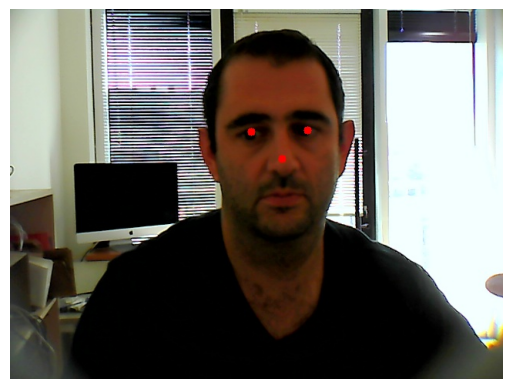

In [3]:
import matplotlib.pyplot as plt
img = cv2.imread("img_mat.jpg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.axis('off')  # Turn off axis numbers and ticks
plt.show()


In [4]:
def get_face_from_pose(pose_results,img):
    keypoints_result = pose_results.keypoints if  hasattr(pose_results,'keypoints') else None
    if keypoints_result is None:
        raise IndexError("No keypoints in the results")
    face_all_data = {}
    for keypoint in keypoints_result:
        nose = keypoints.check_nose(keypoint)
        eyes = keypoints.check_eyes(keypoint)
        if nose is None or eyes is None:
            continue
        x, y, w, h = find_face(nose, eyes[0], eyes[1], img.shape )
        if h <= 0 or w <= 0:
                continue
        face = img[y:y+h,x:x+w]
        face_all_data["face"] = face        
        face_all_data["posn"] = [x+w//2,y+h//2,w,h]
    return face_all_data



In [5]:
from img_xtend.pose_estimation.keypoints import *
from copy import deepcopy

def show_pose(img, pose_result):
    
    img_new = deepcopy(img)
    # Define the color (BGR format) and radius of the point
    color = (0, 0, 255)  # Red color in BGR format
    radius = 5  # Radius of the circle (point size)
    thickness = -1  # -1 fills the circle to make it a solid dot
    
    pose_keypoint = pose_result.keypoints
    eyes = check_eyes(pose_keypoint)
    nose = check_nose(pose_keypoint)
    points = []
    # joint_points = [eyes
    if isinstance(eyes, torch.Tensor):
        for i in range(eyes.shape[0]):
            points.append((eyes[i,0].item(), eyes[i,1].item()))
    if isinstance(nose, torch.Tensor):
        points.append((nose[0].item(), nose[1].item()))
        
    for point in points:
        cv2.circle(img_new, point, radius, color, thickness)
    return img_new




In [34]:
def find_face(nose,left_eye,right_eye,img_shape):
    """The function find a bounding box of the face
    given two eyes' and  nose's coordinates

    Args:
        nose ([type]): [description]
        left_eye ([type]): [description]
        right_eye ([type]): [description]

    Returns:
        [type]: [description]
    """
    left_eye = left_eye.numpy()   # will be on the right  [0] x-> column [1] y -> row
    right_eye = right_eye.numpy()  # will be on the left
    nose = nose.numpy()
    
    dist_eye_x  = left_eye[0] - right_eye[0]   # distance in column
    print(f"{dist_eye_x=}")
    dist_eye_y  = left_eye[1] - right_eye[1]    # distance in rows
    
    if dist_eye_x == 0:
        dist_eye_x = 20

    slope_eye = dist_eye_y/dist_eye_x
    print(f"{slope_eye=}")
    b_left = left_eye[1] - slope_eye*left_eye[0]
    b_right = left_eye[1] - slope_eye*right_eye[0]

    hypo = np.sqrt(dist_eye_x**2 + dist_eye_y**2)

    # proportion = 2 # original
    proportion = 1 # original
    # x_left_new = left_eye[0] - proportion*dist_eye_x # original
    x_left_new = right_eye[0] - proportion*dist_eye_x
    y_left_new = left_eye[1] - proportion*dist_eye_y

    # x_right_new = right_eye[0] + proportion*dist_eye_x # orignal
    x_right_new = left_eye[0] + proportion*dist_eye_x
    y_right_new = right_eye[1] + proportion*dist_eye_y

    x_final = np.max((0,np.round(x_left_new).astype(int)))

    width = np.min((img_shape[1]-x_final-1, np.round(x_right_new - x_left_new).astype(int)))
    # print(f"{x_left_new=} , {x_right_new=} , {width=}")

    x_m = right_eye[0] + 0.5*dist_eye_x
    y_m = right_eye[1] + 0.5*dist_eye_y

    dist_nose_x = nose[0] - x_m
    dist_nose_y = nose[1] - y_m

    proportion2 = 3.5 # original
    x_high_new = nose[0] - proportion2*dist_nose_x
    y_high_new = nose[1] - (proportion2+1.5)*dist_nose_y

    x_down_new = x_m + (proportion2)*dist_nose_x
    # y_down_new = y_m + proportion2*dist_nose_y # original
    y_down_new = nose[1] + proportion2*dist_nose_y

    y_final = np.max((0,np.round(y_high_new).astype(int)))
    height = np.min((img_shape[0]-y_final-1, np.round(y_down_new - y_high_new).astype(int)))
    print(f"{nose[1]=} {y_high_new=}, {y_down_new=}, {height=}")
    return x_final , y_final , height , width

eyes=tensor([[386, 157],
        [313, 159]], dtype=torch.int32)
dist_eye_x=73
slope_eye=-0.0273972602739726
nose[1]=194 y_high_new=14.0, y_down_new=320.0, height=306
x=240, y=14, w=219, h=306
x+w=459
(480, 640, 3)


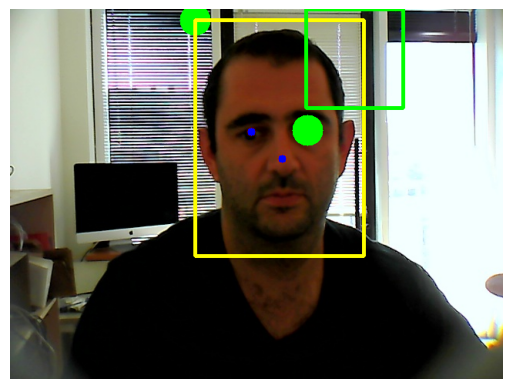

In [35]:
new_img = None
new_img = show_pose(img, pose_result)
nose = check_nose(pose_result.keypoints)
eyes = check_eyes(pose_result.keypoints)
print(f"{eyes=}")
x,y,h,w = find_face(nose,eyes[0],eyes[1],img.shape)
print(f"{x=}, {y=}, {w=}, {h=}")
color = (255,255,0)
thickness = 3
cv2.circle(new_img, (x,y), 20, (0,255,0), -1)
pt1 = (x,y)
pt2 = (x+w, y+h)
print(f"x+w={x+w}")
cv2.rectangle(new_img, pt1, pt2, color, thickness)
cv2.rectangle(new_img,(384,0),(510,128),(0,255,0),3)
nose = nose.numpy()
eyes = eyes.numpy()
left_eye = eyes[0]
# cv2.circle(new_img, (nose[0],nose[1]), 20, (0,255,0), -1)
cv2.circle(new_img, (left_eye[0],left_eye[1]), 20, (0,255,0), -1)

print(img.shape)
plt.imshow(new_img)
plt.axis('off')  # Turn  axis numbers and ticks
plt.show()


In [20]:
print(f"{x=}, {y=}, {w=}, {h=}")

240

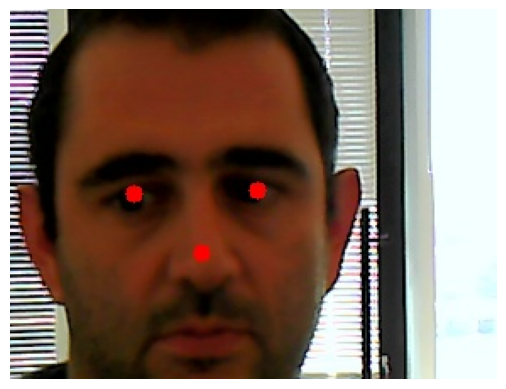

In [10]:
type(img)
face = img[y:y+h,x:x+w]
face.shape
plt.imshow(face)
plt.axis('off')  # Turn off axis numbers and ticks
plt.show()
